In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd

from enum import Enum
from typing import List
from PIL import Image, ImageDraw, ImageFont


## Mondrian Map Visualization

In [3]:
for csv_file in sorted(os.listdir("../data/case_study/pathways_prepared_for_visualization/")):
    if "csv" in csv_file:
        df = pd.read_csv("../data/case_study/pathways_prepared_for_visualization/" + csv_file)
        print(df.shape)
print(csv_file)
df

(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
wikipathway_nonaggressive_R2_TP.csv


,GS_ID,wFC,pFDR,x,y
0,WAG002048,1.1786,5.255072e-35,919.979510,328.649573
1,WAG002628,1.3226,7.458901e-30,200.916562,272.423214
2,WAG002876,1.5974,2.492753e-29,723.961502,691.891638
3,WAG002783,1.5567,1.655330e-28,445.602962,452.578657
4,WAG002483,1.5567,1.657112e-28,636.837443,583.915186
5,WAG003212,1.2251,2.035658e-27,180.720278,392.922252
6,WAG002133,1.2647,4.539110e-26,607.298815,220.621129
7,WAG002068,1.5841,1.304305e-24,544.560992,545.511824
8,WAG002134,1.1587,5.792609e-24,704.595680,265.673499
9,WAG003247,1.3524,7.989724e-24,501.159242,285.843218


In [4]:
LINE_WIDTH = 5
THIN_LINE_WIDTH = 1
adjust = LINE_WIDTH // 2
adjust_e = adjust + 1
adjust_d = adjust_e - adjust

AREA_SCALAR = 4000

up_th = 1.25
dn_th = abs(1-(up_th-1))

# for data preparation
def get_points(df, scale=1):
    return [(round(df['x'].iloc[i] * scale, 2), round(df['y'].iloc[i] * scale, 2)) for i in range(len(df))]

def get_areas(df, scale):
    return list(abs(np.log2(df["wFC"])) * scale)

def get_colors(df, up_th, dn_th):
    colors = []
    for i, row in df.iterrows():
        if row["pFDR"] < 0.05:
            if row["wFC"] >= up_th:
                colors.append("red")
            elif row["wFC"] <= dn_th:
                colors.append("blue")
            else:
                colors.append("yellow")
        else:
            colors.append("black")
    return colors

def get_IDs(df):
    return [i[-4:] for i in df["GS_ID"]]

def get_relations(mem_df, th=2):
    relations = []
    rel_count = {}
    for key in set(mem_df["GS_A_ID"]):
        rel_count[key[-4:]] = 0
    for index, row in mem_df.iterrows():
        if (row["GS_B_ID"][-4:], row["GS_A_ID"][-4:]) not in relations and \
        rel_count[row["GS_A_ID"][-4:]] < th and rel_count[row["GS_B_ID"][-4:]] < th:
            relations.append((row["GS_A_ID"][-4:], row["GS_B_ID"][-4:]))
            rel_count[row["GS_A_ID"][-4:]] += 1
            rel_count[row["GS_B_ID"][-4:]] += 1
    return relations

### Core Utility

def blank_canvas():
    Corner.instances = []
    Block.instances = {}
    Line.instances = []

class Colors(str, Enum):
    WHITE = "#FFFFFF"
    # RED = "#dd271c"   # mine
    # BLUE = "#015da1"
    # YELLOW = "#f2dd74"

    GRAY = "#3e3f39"    # https://color.adobe.com/De-Stijl---Piet-Mondrian-color-theme-6225068/
    BLACK = "#050103"
    BLACK_A = "#05010333"
    BLACK_AA = "#050103AA"
    
    RED = "#E70503"
    BLUE = "#0300AD"
    YELLOW = "#FDDE06"

    RED_A = "#E70503AA"
    BLUE_A = "#0300ADAA"
    YELLOW_A = "#FDDE06AA"

    SOLID = [RED, BLUE, YELLOW, GRAY, BLACK]
    TRANS = [RED_A, BLUE_A, YELLOW_A, BLACK_A]

def get_color_map(color):
    if color == "red": return Colors.RED
    if color == "blue": return Colors.BLUE
    if color == "yellow": return Colors.YELLOW
    if color == "black": return Colors.BLACK
    if color == "gray": return Colors.GRAY

    if color == "red_a": return Colors.RED_A
    if color == "blue_a": return Colors.BLUE_A
    if color == "yellow_a": return Colors.YELLOW_A
    if color == "black_a": return Colors.BLACK_A

class Ratio(float, Enum):
    SQUARE = 1
    GOLDEN_H = 1/1.6
    GOLDEN_W = 1.6/1
    LONG_H = 1/2
    LONG_W = 2/1

class CornerPos(int, Enum):
    TOP_LEFT = 0
    TOP_RIGHT = 1
    BOTTOM_LEFT = 2
    BOTTOM_RIGHT = 3

class LineDir(str, Enum):
    RIGHT = "left_to_right"
    LEFT = "right_to_left"
    DOWN = "up_to_down"
    UP = "down_to_up"


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return f"({round(self.x, 2)}, {round(self.y, 2)})"

class Line:
    instances = []
    def __init__(self, point_a: Point, point_b: Point, direction: LineDir, color: Colors = Colors.BLACK, strength: int = LINE_WIDTH):
        self.point_a = point_a
        self.point_b = point_b
        self.direction = direction
        self.color = color
        self.strength = strength
        self.instances.append(self)

    def __str__(self):
        return f"({self.point_a.x}, {self.point_a.y}) to ({self.point_b.x}, {self.point_b.y})"

    def draw(self, image: Image.Image):
        draw = ImageDraw.Draw(image)
        draw.line((self.point_a.x, self.point_a.y, self.point_b.x, self.point_b.y), fill=self.color, width=self.strength)

class Corner:
    instances = []

    def __init__(self, point: Point, position: CornerPos, line: Line = None):
        self.point = point
        self.position = position
        self.line = line
        self.instances.append(self)

    def __str__(self):
        return f"{self.position}: ({round(self.point.x, 2)}, {round(self.point.y, 2)})"

    def draw(self, image: Image.Image):
        draw = ImageDraw.Draw(image)
        draw.ellipse((self.point.x, self.point.y, self.point.x, self.point.y), fill=Colors.BLUE)


class Block:
    instances = {}
    def __init__(self, top_left, bottom_right, area: float, color: Colors, id: str):
        self.top_left_p = top_left
        self.bottom_right_p = bottom_right

        self.top_left = Corner(Point(self.top_left_p[0] - adjust, self.top_left_p[1] - adjust), CornerPos.TOP_LEFT)
        self.top_right = Corner(Point(self.bottom_right_p[0] + adjust, self.top_left_p[1] - adjust), CornerPos.TOP_RIGHT)
        self.bottom_left = Corner(Point(self.top_left_p[0] - adjust, self.bottom_right_p[1] + adjust), CornerPos.BOTTOM_LEFT)
        self.bottom_right = Corner(Point(self.bottom_right_p[0] + adjust, self.bottom_right_p[1] + adjust), CornerPos.BOTTOM_RIGHT)

        self.center = Point((self.top_left.point.x + self.bottom_right.point.x) / 2, (self.top_left.point.y + self.bottom_right.point.y) / 2)
        self.area = area
        self.color = get_color_map(color)
        self.id = id
        self.instances[id] = self

        Line(Point(self.top_left.point.x, self.top_left.point.y + adjust), Point(self.top_right.point.x, self.top_right.point.y + adjust), LineDir.RIGHT)
        Line(Point(self.top_right.point.x - adjust, self.top_right.point.y), Point(self.bottom_right.point.x - adjust, self.bottom_right.point.y), LineDir.DOWN)
        Line(Point(self.bottom_right.point.x, self.bottom_right.point.y - adjust), Point(self.bottom_left.point.x, self.bottom_left.point.y - adjust), LineDir.LEFT)
        Line(Point(self.bottom_left.point.x + adjust, self.bottom_left.point.y), Point(self.top_left.point.x + adjust, self.top_left.point.y), LineDir.UP)

    def __str__(self):
        return f"Block ID: {self.id}"

    @property
    def height(self):
        return self.bottom_left.point.x - self.top_left.point.x

    @property
    def width(self):
        return self.top_right.point.x - self.top_left.point.x

    def draw(self, image: Image.Image):
        draw = ImageDraw.Draw(image)

        left_upper = (self.top_left.point.x, self.top_left.point.y)
        right_lower = (self.bottom_right.point.x, self.bottom_right.point.y)
        if self.color in Colors.SOLID:
            border_color = Colors.BLACK
        else:
            border_color = Colors.BLACK_A
        draw.rectangle([left_upper, right_lower], outline=Colors.BLACK, fill=self.color, width=LINE_WIDTH)

        if self.color == Colors.YELLOW:
            annot_color = Colors.BLACK
            background_color = Colors.YELLOW_A
        else:
            if self.color == Colors.RED:
                background_color = Colors.RED_A
            elif self.color == Colors.BLUE:
                background_color = Colors.BLUE_A
            elif self.color == Colors.BLACK:
                background_color = Colors.BLACK_AA
            annot_color = Colors.WHITE
        if self.width < self.height:
            direction = "ttb"
        else:
            direction = 'ltr'
#         draw.text((self.top_left.point.x+5, self.top_left.point.y+3.5), str(self.id)[-4:],
#                     fill=annot_color, font=ImageFont.truetype("arial_bold.ttf", round(np.log2(self.area)*1.2)),
#                     direction=direction)

#         draw.text(((self.top_left.point.x+self.top_right.point.x)//2, (self.top_left.point.y+self.top_right.point.y)//2-35), str(self.id)[:],
#                     fill="#787878", font=ImageFont.truetype("../static/arial_bold.ttf", 20),  # round(np.log2(self.area)*1.2)
#                     direction=direction)

        # Calculate the center point for text alignment
        text_x = (self.top_left.point.x + self.top_right.point.x) // 2
        text_y = (self.top_left.point.y + self.top_right.point.y) // 2 - 20

        # Define the text
        text = str(self.id)[:]

        # Load the font
        font = ImageFont.truetype("../static/arial_bold.ttf", 21)

        # Get the bounding box of the text (left, top, right, bottom)
        text_bbox = draw.textbbox((0, 0), text, font=font)

        # Calculate the size of the text
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1] + 6

        # Calculate the position to center the text
        text_position = (text_x - text_width // 2, text_y - text_height // 2)

#         radius = 1  # Radius for the rounded corners
#         draw.rounded_rectangle([(text_position[0]-1, text_position[1]), (text_position[0] + text_width, text_position[1] + text_height)], 
#                                fill=background_color, radius=radius)
        
        border_color = Colors.BLACK_AA
        border_width = 3  # Thickness of the border
        radius = 1  # Radius for the rounded corners

        # Draw the rounded rectangle with the border
        draw.rounded_rectangle(
            [text_position[0] - border_width - 2, text_position[1] - border_width + 2, 
             text_position[0] + text_width + border_width + 2, text_position[1] + text_height + border_width],
            fill=background_color, outline=border_color, width=border_width, radius=radius)

        # Draw the text
        draw.text(text_position, text, fill=annot_color, font=font, direction=direction)

def get_closest_corner(block_a: Block, block_b: Block) -> Corner:
    min_distance = float('inf')
    closest_corner = None

    for corner in [block_a.top_left, block_a.top_right, block_a.bottom_right, block_a.bottom_left]:
        distance = abs(corner.point.x - block_b.center.x) + abs(corner.point.y - block_b.center.y)
        if distance < min_distance:
            min_distance = distance
            closest_corner = corner

    return closest_corner

def get_line_direction(point_a: Point, point_b: Point):
    # if point_a.x == point_b.x and point_a.y == point_b.y:
    #     return LineDir.NONE
    if abs(point_a.x - point_b.x) <= adjust:     # due to adjustment error
        if point_a.y < point_b.y:
            return LineDir.DOWN
        else:
            return LineDir.UP
    elif abs(point_a.y - point_b.y) <= adjust:
        if point_a.x < point_b.x:
            return LineDir.RIGHT
        else:
            return LineDir.LEFT
    else:
        print(point_a, point_b)
        print("WARNING: line.direction is None")
        return None

def filtered_blocks(relation):
    return [Block.instances[bid] for bid in Block.instances.keys() if bid not in relation]

def check_manhattan_line_intersection(manhattan_lines, rel):
    """RETURNS TRUE IF INTERSECTION HAPPENS"""
    for line in manhattan_lines:
        for blk in filtered_blocks(rel):
            if is_line_intersecting_rectangle((line.point_a, line.point_b), (blk.top_left.point, blk.bottom_right.point)):
                return True
    return False

def get_manhattan_lines(corner_a: Corner, corner_b: Corner) -> List[Line]:
    if corner_a.point.x == corner_b.point.x and corner_a.point.y != corner_b.point.y:
        print("VERTICAL MANHATTAN LINE")
        if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.BOTTOM_LEFT]:
            line_v = Line(Point(corner_a.point.x + adjust, corner_a.point.y), Point(corner_b.point.x + adjust, corner_b.point.y), get_line_direction(corner_a.point, corner_b.point))
        if corner_a.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT]:
            line_v = Line(Point(corner_a.point.x - adjust, corner_a.point.y), Point(corner_b.point.x - adjust, corner_b.point.y), get_line_direction(corner_a.point, corner_b.point))
        corner_a.line = line_v
        corner_b.line = line_v
        return [line_v]

    elif (corner_a.point.x != corner_b.point.x and corner_a.point.y == corner_b.point.y):
        print("HORIZONTAL MANHATTAN LINE")
        if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.TOP_RIGHT]:
            line_h = Line(Point(corner_a.point.x, corner_a.point.y + adjust), Point(corner_b.point.x, corner_b.point.y + adjust), get_line_direction(corner_a.point, corner_b.point))
        elif corner_a.position in [CornerPos.BOTTOM_LEFT, CornerPos.BOTTOM_RIGHT]:
            line_h = Line(Point(corner_a.point.x, corner_a.point.y - adjust), Point(corner_b.point.x, corner_b.point.y - adjust), get_line_direction(corner_a.point, corner_b.point))
        corner_a.line = line_h
        corner_b.line = line_h
        return [line_h]

    elif corner_a.point.x != corner_b.point.x and corner_a.point.y != corner_b.point.y:
        # DECISION POINT: large > small or small > large
        if (corner_a.point.x - corner_b.point.x) > abs(corner_a.point.y - corner_b.point.y):
            connector = Point(corner_a.point.x, corner_b.point.y)
        else:
            connector = Point(corner_b.point.x, corner_a.point.y)

        if corner_a.position in [CornerPos.TOP_LEFT] and get_line_direction(corner_a.point, connector) in [LineDir.RIGHT, LineDir.LEFT]:
            corner_a_point = Point(corner_a.point.x - adjust_d, corner_a.point.y + adjust)
            connector = Point(connector.x, connector.y + adjust)

        elif corner_a.position in [CornerPos.TOP_RIGHT] and get_line_direction(corner_a.point, connector) in [LineDir.RIGHT, LineDir.LEFT]:
            corner_a_point = Point(corner_a.point.x + adjust_d, corner_a.point.y + adjust)
            connector = Point(connector.x, connector.y + adjust)       # DEBUG

        elif corner_a.position in [CornerPos.TOP_RIGHT] and get_line_direction(corner_a.point, connector) in [LineDir.UP, LineDir.DOWN]:
            corner_a_point = Point(corner_a.point.x - adjust, corner_a.point.y - adjust_d)
            connector = Point(connector.x - adjust, connector.y)

        elif corner_a.position in [CornerPos.BOTTOM_RIGHT] and get_line_direction(corner_a.point, connector) in [LineDir.UP, LineDir.DOWN]:
            corner_a_point = Point(corner_a.point.x - adjust, corner_a.point.y + adjust_d)
            connector = Point(connector.x - adjust, connector.y)

        elif corner_a.position in [CornerPos.BOTTOM_RIGHT] and get_line_direction(corner_a.point, connector) in [LineDir.RIGHT, LineDir.LEFT]:
            corner_a_point = Point(corner_a.point.x + adjust_d, corner_a.point.y - adjust)
            connector = Point(connector.x, connector.y - adjust)

        elif corner_a.position in [CornerPos.BOTTOM_LEFT] and get_line_direction(corner_a.point, connector) in [LineDir.RIGHT, LineDir.LEFT]:
            corner_a_point = Point(corner_a.point.x - adjust_d, corner_a.point.y - adjust)
            connector = Point(connector.x, connector.y - adjust)

        elif corner_a.position in [CornerPos.BOTTOM_LEFT] and get_line_direction(corner_a.point, connector) in [LineDir.UP, LineDir.DOWN]:
            corner_a_point = Point(corner_a.point.x + adjust, corner_a.point.y + adjust_d)    # DEBUG
            connector = Point(connector.x + adjust, connector.y)

        elif corner_a.position in [CornerPos.TOP_LEFT] and get_line_direction(corner_a.point, connector) in [LineDir.UP, LineDir.DOWN]:
            corner_a_point = Point(corner_a.point.x + adjust, corner_a.point.y - adjust_d)    # DEBUG
            connector = Point(connector.x + adjust, connector.y)

        line_a = Line(corner_a_point, connector, get_line_direction(corner_a_point, connector), color=Colors.RED, strength=LINE_WIDTH)

        if corner_b.position in [CornerPos.TOP_LEFT, CornerPos.TOP_RIGHT] and get_line_direction(connector, corner_b.point) in [LineDir.RIGHT, LineDir.LEFT]:
            if get_line_direction(connector, corner_b.point) == LineDir.RIGHT:
                connector = Point(connector.x - adjust, connector.y + adjust)
            elif get_line_direction(connector, corner_b.point) == LineDir.LEFT:
                connector = Point(connector.x + adjust, connector.y + adjust)

            if corner_b.position == CornerPos.TOP_RIGHT:            # and get_line_direction(connector, corner_b.point) == LineDir.LEFT
                corner_b_point = Point(corner_b.point.x + adjust_d, corner_b.point.y + adjust)

            elif corner_b.position == CornerPos.TOP_LEFT:           #  and get_line_direction(connector, corner_b.point) == LineDir.RIGHT
                corner_b_point = Point(corner_b.point.x - adjust_d, corner_b.point.y + adjust)

        elif corner_b.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT] and get_line_direction(connector, corner_b.point) in [LineDir.DOWN, LineDir.UP]:
            if get_line_direction(connector, corner_b.point) == LineDir.DOWN:
                connector = Point(connector.x - adjust, connector.y - adjust)
            elif get_line_direction(connector, corner_b.point) == LineDir.UP:
                connector = Point(connector.x - adjust, connector.y + adjust)

            if corner_b.position == CornerPos.TOP_RIGHT:                # and get_line_direction(connector, corner_b.point) == LineDir.DOWN
                corner_b_point = Point(corner_b.point.x - adjust, corner_b.point.y - adjust_d)
            elif corner_b.position == CornerPos.BOTTOM_RIGHT:           #  and get_line_direction(connector, corner_b.point) == LineDir.UP
                corner_b_point = Point(corner_b.point.x - adjust, corner_b.point.y + adjust_d)

        elif corner_b.position in [CornerPos.BOTTOM_RIGHT, CornerPos.BOTTOM_LEFT] and get_line_direction(connector, corner_b.point) in [LineDir.RIGHT, LineDir.LEFT]:
            if get_line_direction(connector, corner_b.point) == LineDir.RIGHT:
                connector = Point(connector.x - adjust, connector.y - adjust)
            elif get_line_direction(connector, corner_b.point) == LineDir.LEFT:
                connector = Point(connector.x + adjust, connector.y - adjust)

            if corner_b.position == CornerPos.BOTTOM_RIGHT:         # and get_line_direction(connector, corner_b.point) == LineDir.LEFT
                corner_b_point = Point(corner_b.point.x + adjust_d, corner_b.point.y - adjust)
            elif corner_b.position == CornerPos.BOTTOM_LEFT:        #  and get_line_direction(connector, corner_b.point) == LineDir.RIGHT
                corner_b_point = Point(corner_b.point.x - adjust_d, corner_b.point.y - adjust)

        elif corner_b.position in [CornerPos.BOTTOM_LEFT, CornerPos.TOP_LEFT] and get_line_direction(connector, corner_b.point) in [LineDir.DOWN, LineDir.UP]:
            if get_line_direction(connector, corner_b.point) == LineDir.DOWN:
                connector = Point(connector.x + adjust, connector.y - adjust)
            elif get_line_direction(connector, corner_b.point) == LineDir.UP:
                connector = Point(connector.x + adjust, connector.y + adjust)

            if corner_b.position == CornerPos.TOP_LEFT:             #  and get_line_direction(connector, corner_b.point) == LineDir.DOWN
                corner_b_point = Point(corner_b.point.x + adjust, corner_b.point.y - adjust_d)
            elif corner_b.position == CornerPos.BOTTOM_LEFT:        #  and get_line_direction(connector, corner_b.point) == LineDir.UP      # DEBUG
                corner_b_point = Point(corner_b.point.x + adjust, corner_b.point.y + adjust_d)

        line_b = Line(connector, corner_b_point, get_line_direction(connector, corner_b_point), color=Colors.RED, strength=LINE_WIDTH)

        # if line_a is overlapping, return only line_b
        if line_a.direction in [LineDir.LEFT, LineDir.RIGHT]:
            horizontal_lines = [line for line in Line.instances if line.direction in [LineDir.LEFT, LineDir.RIGHT] and line_a != line]
            overlapping = is_overlapping_h(line_a, horizontal_lines)
            if overlapping:
                corner_b.line = line_b
                return [line_b]
        elif line_a.direction in [LineDir.UP, LineDir.DOWN]:
            vertical_lines = [line for line in Line.instances if line.direction in [LineDir.UP, LineDir.DOWN] and line_a != line]
            overlapping = is_overlapping_v(line_a, vertical_lines)
            if overlapping:
                corner_b.line = line_b
                return [line_b]

        # if line_b is overlapping, return only line_a
        if line_b.direction in [LineDir.LEFT, LineDir.RIGHT]:
            horizontal_lines = [line for line in Line.instances if line.direction in [LineDir.LEFT, LineDir.RIGHT] and line_b != line]
            overlapping =  is_overlapping_h(line_b, horizontal_lines)
            if overlapping:
                corner_a.line = line_a
                return [line_a]
        elif line_b.direction in [LineDir.UP, LineDir.DOWN]:
            vertical_lines = [line for line in Line.instances if line.direction in [LineDir.UP, LineDir.DOWN] and line_b != line]
            overlapping = is_overlapping_v(line_b, vertical_lines)
            if overlapping:
                corner_a.line = line_a
                return [line_a]

        corner_a.line = line_a
        corner_b.line = line_b
        # print(f'corner_a_line {corner_a.line}')
        # print(f'corner_b_line {corner_b.line}')
        return [line_a, line_b]

def is_overlapping_h(line1, horizontal_lines):
    assert line1.point_a.y == line1.point_b.y
    y1 = line1.point_a.y  # Y-coordinate of the given line

    for line2 in horizontal_lines:
        y2 = line2.point_a.y

        # Check if Y-coordinates match
        if y1 == y2:
            assert line1.point_a.y == line1.point_b.y == line2.point_a.y == line2.point_b.y
            # Check if X-ranges overlap
            l1pa_in_l2 = ((line2.point_a.x - adjust) <= line1.point_a.x <= (line2.point_b.x + adjust)) or ((line2.point_a.x + adjust) >= line1.point_a.x >= (line2.point_b.x - adjust))
            l1pb_in_l2 = ((line2.point_a.x - adjust) <= line1.point_b.x <= (line2.point_b.x + adjust)) or ((line2.point_a.x + adjust) >= line1.point_b.x >= (line2.point_b.x - adjust))
            if l1pa_in_l2 and l1pb_in_l2:
                return True

    return False

def is_overlapping_v(line1, vertical_lines):
    assert line1.point_a.x == line1.point_b.x
    x1 = line1.point_a.x  # X-coordinate of the given line

    for line2 in vertical_lines:
        x2 = line2.point_a.x

        # Check if X-coordinates match
        if x1 == x2:
            assert line1.point_a.x == line1.point_b.x == line2.point_a.x == line2.point_b.x
            # Check if Y-ranges overlap
            l1pa_in_l2 = ((line2.point_a.y - adjust) <= line1.point_a.y <= (line2.point_b.y + adjust)) or ((line2.point_a.y + adjust) >= line1.point_a.y >= (line2.point_b.y - adjust))
            l1pb_in_l2 = ((line2.point_a.y - adjust) <= line1.point_b.y <= (line2.point_b.y + adjust)) or ((line2.point_a.y + adjust) >= line1.point_b.y >= (line2.point_b.y - adjust))
            if l1pa_in_l2 and l1pb_in_l2:
                return True

    return False

def approximate_grid_layout(nob):
    """Approximates the number of rows and columns to arrange a given number of objects."""

    if nob <= 0:
        return 0, 0  # Handle invalid input

    # Find the closest perfect square less than or equal to nob
    approx_side = math.floor(math.sqrt(nob))

    # Calculate ideal rows and columns based on a square arrangement
    ideal_rows = approx_side
    ideal_columns = approx_side

    # Adjust if needed to distribute objects more evenly
    remainder = nob - (ideal_rows * ideal_columns)
    if remainder > 0:
        if remainder <= ideal_columns:
            ideal_rows += 1  # Add a row
        else:
            ideal_columns += 1  # Add a column

    return ideal_rows, ideal_columns

class GridSystem:
    def __init__(self, canvas_width, canvas_height, block_width, block_height):
        self.canvas_width = canvas_width
        self.canvas_height = canvas_height
        self.block_width = block_width          # h
        self.block_height = block_height        # v
        self.grid_lines_h = {f'h{i}': i * self.block_width for i in range(self.canvas_height // self.block_width + 1)}
        self.grid_lines_v = {f'v{i}': i * self.block_height for i in range(self.canvas_width // self.block_height + 1)}

    def calculate_block_sizes(self):
        horizontal_sizes = [y - prev_y for prev_y, y in zip([0] + list(self.grid_lines_h.values()), list(self.grid_lines_h.values()) + [self.canvas_height])]
        vertical_sizes = [x - prev_x for prev_x, x in zip([0] + list(self.grid_lines_v.values()), list(self.grid_lines_v.values()) + [self.canvas_width])]
        return horizontal_sizes, vertical_sizes


    def draw_grid(self):
        image = Image.new('RGB', (self.canvas_width, self.canvas_height), color='white')
        draw = ImageDraw.Draw(image)

        # Calculate block sizes dynamically
        horizontal_sizes, vertical_sizes = self.calculate_block_sizes()

        # Draw horizontal lines
        for i, size in self.grid_lines_h.items():
            draw.line([(0, size), (self.canvas_width, size)], fill='#999999', width=THIN_LINE_WIDTH)

        # Draw vertical lines
        for i, size in self.grid_lines_v.items():
            draw.line([(size, 0), (size, self.canvas_height)], fill='#999999', width=THIN_LINE_WIDTH)

        return image, draw

    def remove_grid_line(self, grid_id):
        orientation, line_id = grid_id[0], int(grid_id[1:])
        if orientation == 'h' and grid_id in self.grid_lines_h:
            del self.grid_lines_h[grid_id]
        elif orientation == 'v' and grid_id in self.grid_lines_v:
            del self.grid_lines_v[grid_id]

    def fill_blocks_around_point(self, point, target_area):
        x, y = point

        # Find the block IDs for the given point
        block_id_h = f'h{y // self.block_height}'
        block_id_v = f'v{x // self.block_width}'

        # Calculate the number of blocks to be filled based on the target area
        nob = max(1, round(target_area / (self.block_width * self.block_height)))
        num_rows, num_columns = approximate_grid_layout(nob)

        area_diff = abs(target_area - nob * self.block_width * self.block_height)
        # print(f"Rectangle: true area: {target_area} | block_area: {nob * self.block_width * self.block_height} | {target_area / (self.block_width * self.block_height)} -> {round(target_area / (self.block_width * self.block_height))} | {num_rows}x{num_columns}")

        # Adjust the starting block to ensure the point is in the center
        start_block_h = max(int(y // self.block_height - num_rows // 2), 1)
        start_block_v = max(int(x // self.block_width - num_columns // 2), 1)

        start_block_h = min(start_block_h, len(self.grid_lines_h.keys()) - num_rows)
        start_block_v = min(start_block_v, len(self.grid_lines_v.keys()) - num_columns)

        # Calculate the coordinates for the single rectangle around the point
        top_left_x = self.grid_lines_v[f'v{start_block_v}']
        top_left_y = self.grid_lines_h[f'h{start_block_h}']
        bottom_right_x = self.grid_lines_v[f'v{start_block_v + num_columns - 1}'] + self.block_width
        bottom_right_y = self.grid_lines_h[f'h{start_block_h + num_rows - 1}'] + self.block_height

        # # Remove intersecting horizontal lines
        # for i in range(start_block_h + 1, start_block_h + num_rows):
        #     line_id = f'h{i}'
        #     self.remove_grid_line(line_id)

        # # Remove intersecting vertical lines
        # for j in range(start_block_v + 1, start_block_v + num_columns):
        #     line_id = f'v{j}'
        #     self.remove_grid_line(line_id)

        return [(top_left_x, top_left_y), (bottom_right_x, bottom_right_y)], area_diff

    def plot_points_fill_blocks(self, points, target_areas, visualize=True):
        if visualize:
            image, draw = self.draw_grid()
        rectangles = []

        # Increase the size of the plotted points for better visibility
        point_size = 3
        area_diff = 0

        for point, target_area in zip(points, target_areas):
            x, y = point

            # Find the block IDs for the given point
            # block_id_h = f'h{y // self.block_height}'
            # block_id_v = f'v{x // self.block_width}'
            # print(f'Point ({x}, {y}) is in block {block_id_h}, {block_id_v}')

            # Fill blocks around the point based on the target area
            rect, diff = self.fill_blocks_around_point(point, target_area)
            rectangles.append(rect)
            area_diff += diff


        # adjustment
        if visualize:
            # for (top_left_x, top_left_y), (bottom_right_x, bottom_right_y) in rectangles:
            #     draw.rectangle([(top_left_x - adjust, top_left_y - adjust), (bottom_right_x + adjust, bottom_right_y + adjust)], fill=None, outline="black", width=LINE_WIDTH)

            for x, y in points:
                draw.ellipse((x - point_size, y - point_size, x + point_size, y + point_size), fill='blue')


        def calculate_overlapped_area(rectangles):
            total_area = 0
            n = len(rectangles)

            for i in range(n - 1):
                for j in range(i + 1, n):
                    rect1 = rectangles[i]
                    rect2 = rectangles[j]

                    x_overlap = max(0, min(rect1[1][0], rect2[1][0]) - max(rect1[0][0], rect2[0][0]))
                    y_overlap = max(0, min(rect1[1][1], rect2[1][1]) - max(rect1[0][1], rect2[0][1]))

                    overlap_area = x_overlap * y_overlap
                    total_area += overlap_area

            return total_area
        overlap = calculate_overlapped_area(rectangles)
        # print(f"OVERLAPPED AREA: {overlap}")
        # print(f"AREA DIFF: {area_diff}")
        score = overlap + area_diff
        if visualize:
            return rectangles, image, overlap
        else:
            return rectangles, overlap
        
def block_position(block_a: Block, block_b: Block) -> dict:
    """
        USAGE: block_position(Block.instances["001"], Block.instances["003"])
    """
    return {
        "up": block_b.center.y < block_a.center.y,
        "down": block_b.center.y > block_a.center.y,
        "left": block_b.center.x < block_a.center.x,
        "right": block_b.center.x > block_a.center.x
    }

def get_furthest_connector(cp1, cp2, center):
    p = Point(cp1.point.x, cp2.point.y)
    q = Point(cp2.point.x, cp1.point.y)
    if euclidean_distance_point((p.x, p.y), (center.x, center.y)) > euclidean_distance_point((q.x, q.y), (center.x, center.y)):
        return p
    else:
        return q

def get_manhattan_lines_2(corner_a: Corner, corner_b: Corner, connector: Point, color: Colors) -> List[Line]:
    if corner_a.point.x == corner_b.point.x and corner_a.point.y != corner_b.point.y:
        print("VERTICAL MANHATTAN LINE")
        if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.BOTTOM_LEFT]:
            line_v = Line(Point(corner_a.point.x + adjust, corner_a.point.y), Point(corner_b.point.x + adjust, corner_b.point.y), get_line_direction(corner_a.point, corner_b.point), color=color)
        if corner_a.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT]:
            line_v = Line(Point(corner_a.point.x - adjust, corner_a.point.y), Point(corner_b.point.x - adjust, corner_b.point.y), get_line_direction(corner_a.point, corner_b.point), color=color)
        corner_a.line = line_v
        corner_b.line = line_v
        return [line_v]

    elif (corner_a.point.x != corner_b.point.x and corner_a.point.y == corner_b.point.y):
        print("HORIZONTAL MANHATTAN LINE")
        if corner_a.position == CornerPos.TOP_LEFT:
            line_h = Line(Point(corner_a.point.x - adjust_d, corner_a.point.y + adjust), Point(corner_b.point.x, corner_b.point.y + adjust), get_line_direction(corner_a.point, corner_b.point), color=color)
        elif corner_a.position == CornerPos.TOP_RIGHT:
            line_h = Line(Point(corner_a.point.x + adjust_d, corner_a.point.y + adjust), Point(corner_b.point.x, corner_b.point.y + adjust), get_line_direction(corner_a.point, corner_b.point), color=color)
        elif corner_a.position == CornerPos.BOTTOM_LEFT:
            line_h = Line(Point(corner_a.point.x - adjust_d, corner_a.point.y - adjust), Point(corner_b.point.x, corner_b.point.y - adjust), get_line_direction(corner_a.point, corner_b.point), color=color)
        elif corner_a.position == CornerPos.BOTTOM_RIGHT:
            line_h = Line(Point(corner_a.point.x + adjust_d, corner_a.point.y - adjust), Point(corner_b.point.x, corner_b.point.y - adjust), get_line_direction(corner_a.point, corner_b.point), color=color)
        corner_a.line = line_h
        corner_b.line = line_h
        return [line_h]

    line_a_dir = get_line_direction(corner_a.point, connector)
    if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.TOP_RIGHT] and line_a_dir in [LineDir.LEFT, LineDir.RIGHT]:
        if corner_a.position == CornerPos.TOP_RIGHT and line_a_dir == LineDir.RIGHT:
            line_a = Line(Point(corner_a.point.x + adjust_d, corner_a.point.y + adjust), Point(connector.x, connector.y + adjust), line_a_dir, color=color)
        elif corner_a.position == CornerPos.TOP_LEFT and line_a_dir == LineDir.LEFT:
            line_a = Line(Point(corner_a.point.x - adjust_d, corner_a.point.y + adjust), Point(connector.x, connector.y + adjust), line_a_dir, color=color)
        else:
            line_a = Line(Point(corner_a.point.x, corner_a.point.y + adjust), Point(connector.x, connector.y + adjust), line_a_dir, color=color)
    if corner_a.position in [CornerPos.BOTTOM_LEFT, CornerPos.BOTTOM_RIGHT] and line_a_dir in [LineDir.LEFT, LineDir.RIGHT]:
        if corner_a.position == CornerPos.BOTTOM_RIGHT and line_a_dir == LineDir.RIGHT:
            line_a = Line(Point(corner_a.point.x + adjust_d, corner_a.point.y - adjust), Point(connector.x, connector.y - adjust), line_a_dir, color=color)
        elif corner_a.position == CornerPos.BOTTOM_LEFT and line_a_dir == LineDir.LEFT:
            line_a = Line(Point(corner_a.point.x - adjust_d, corner_a.point.y - adjust), Point(connector.x, connector.y - adjust), line_a_dir, color=color)
        else:
            line_a = Line(Point(corner_a.point.x, corner_a.point.y - adjust), Point(connector.x, connector.y - adjust), line_a_dir, color=color)
    if corner_a.position in [CornerPos.TOP_LEFT, CornerPos.BOTTOM_LEFT] and line_a_dir in [LineDir.UP, LineDir.DOWN]:
        if corner_a.position == CornerPos.TOP_LEFT and line_a_dir == LineDir.UP:
            line_a = Line(Point(corner_a.point.x + adjust, corner_a.point.y - adjust_d), Point(connector.x + adjust, connector.y), line_a_dir, color=color)
        elif corner_a.position == CornerPos.BOTTOM_LEFT and line_a_dir == LineDir.DOWN:
            line_a = Line(Point(corner_a.point.x + adjust, corner_a.point.y + adjust_d), Point(connector.x + adjust, connector.y), line_a_dir, color=color)
        else:
            line_a = Line(Point(corner_a.point.x + adjust, corner_a.point.y), Point(connector.x + adjust, connector.y), line_a_dir, color=color)
    if corner_a.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT] and line_a_dir in [LineDir.UP, LineDir.DOWN]:
        if corner_a.position == CornerPos.TOP_RIGHT and line_a_dir == LineDir.UP:
            line_a = Line(Point(corner_a.point.x - adjust, corner_a.point.y - adjust_d), Point(connector.x - adjust, connector.y), line_a_dir, color=color)
        elif corner_a.position == CornerPos.BOTTOM_RIGHT and line_a_dir == LineDir.DOWN:
            line_a = Line(Point(corner_a.point.x - adjust, corner_a.point.y + adjust_d), Point(connector.x - adjust, connector.y), line_a_dir, color=color)
        else:
            line_a = Line(Point(corner_a.point.x - adjust, corner_a.point.y), Point(connector.x - adjust, connector.y), line_a_dir, color=color)

    line_b_dir = get_line_direction(connector, corner_b.point)
    if corner_b.position in [CornerPos.TOP_LEFT, CornerPos.TOP_RIGHT] and line_b_dir in [LineDir.LEFT, LineDir.RIGHT]:
        if corner_b.position == CornerPos.TOP_LEFT and line_b_dir == LineDir.RIGHT:
            line_b = Line(Point(connector.x - adjust*2, connector.y + adjust), Point(corner_b.point.x - adjust_d, corner_b.point.y + adjust), line_b_dir, color=color)
        elif corner_b.position == CornerPos.TOP_RIGHT and line_b_dir == LineDir.LEFT:
            line_b = Line(Point(connector.x + adjust*2, connector.y + adjust), Point(corner_b.point.x + adjust_d, corner_b.point.y + adjust), line_b_dir, color=color)
        else:
            line_b = Line(Point(connector.x, connector.y + adjust), Point(corner_b.point.x, corner_b.point.y + adjust), line_b_dir, color=color)
    if corner_b.position in [CornerPos.BOTTOM_LEFT, CornerPos.BOTTOM_RIGHT] and line_b_dir in [LineDir.LEFT, LineDir.RIGHT]:
        if corner_b.position == CornerPos.BOTTOM_LEFT and line_b_dir == LineDir.RIGHT:
            line_b = Line(Point(connector.x - adjust*2, connector.y - adjust), Point(corner_b.point.x - adjust_d, corner_b.point.y - adjust), line_b_dir, color=color)
        elif corner_b.position == CornerPos.BOTTOM_RIGHT and line_b_dir == LineDir.LEFT:
            line_b = Line(Point(connector.x + adjust*2, connector.y - adjust), Point(corner_b.point.x + adjust_d, corner_b.point.y - adjust), line_b_dir, color=color)
        else:
            line_b = Line(Point(connector.x, connector.y - adjust), Point(corner_b.point.x, corner_b.point.y - adjust), line_b_dir, color=color)
    if corner_b.position in [CornerPos.TOP_LEFT, CornerPos.BOTTOM_LEFT] and line_b_dir in [LineDir.UP, LineDir.DOWN]:
        if corner_b.position == CornerPos.TOP_LEFT and line_b_dir == LineDir.DOWN:
            line_b = Line(Point(connector.x + adjust, connector.y - adjust*2), Point(corner_b.point.x + adjust, corner_b.point.y - adjust_d), line_b_dir, color=color)
        elif corner_b.position == CornerPos.BOTTOM_LEFT and line_b_dir == LineDir.UP:
            line_b = Line(Point(connector.x + adjust, connector.y + adjust*2), Point(corner_b.point.x + adjust, corner_b.point.y + adjust_d), line_b_dir, color=color)
        else:
            line_b = Line(Point(connector.x + adjust, connector.y), Point(corner_b.point.x + adjust, corner_b.point.y), line_b_dir, color=color)
    if corner_b.position in [CornerPos.TOP_RIGHT, CornerPos.BOTTOM_RIGHT] and line_b_dir in [LineDir.UP, LineDir.DOWN]:
        if corner_b.position == CornerPos.TOP_RIGHT and line_b_dir == LineDir.DOWN:
            line_b = Line(Point(connector.x - adjust, connector.y - adjust*2), Point(corner_b.point.x - adjust, corner_b.point.y - adjust_d), line_b_dir, color=color)
        elif corner_b.position == CornerPos.BOTTOM_RIGHT and line_b_dir == LineDir.UP:
            line_b = Line(Point(connector.x - adjust, connector.y + adjust*2), Point(corner_b.point.x - adjust, corner_b.point.y + adjust_d), line_b_dir, color=color)
        else:
            line_b = Line(Point(connector.x - adjust, connector.y), Point(corner_b.point.x - adjust, corner_b.point.y), line_b_dir, color=color)

    corner_a.line = line_a
    corner_b.line = line_b
    return [line_a, line_b]

def get_manhattan_line_color(block_a, block_b):
    if block_a.color == Colors.RED and block_b.color == Colors.RED:
        return Colors.RED
    elif block_a.color == Colors.BLUE and block_b.color == Colors.BLUE:
        return Colors.BLUE
    else:
        return Colors.YELLOW

# def get_manhattan_line_color(block_a, block_b):
#     return Colors.BLACK

# utility for STAGE 2
def get_nearest_horizontal_line_below(point: Point, horizontal_lines):
    filtered_lines = [line for line in horizontal_lines if line.point_a.y - point.y > LINE_WIDTH and ((line.point_a.x <= point.x <= line.point_b.x) or (line.point_b.x <= point.x <= line.point_a.x))]
    if len(filtered_lines):
        return sorted(filtered_lines, key=lambda line: line.point_a.y)[0]
    else:
        return sorted(horizontal_lines, key=lambda line: line.point_a.y)[-1]

def get_nearest_horizontal_line_above(point: Point, horizontal_lines):
    filtered_lines = [line for line in horizontal_lines if point.y - line.point_a.y > LINE_WIDTH and ((line.point_a.x <= point.x <= line.point_b.x) or (line.point_b.x <= point.x <= line.point_a.x))]
    if len(filtered_lines):
        return sorted(filtered_lines, key=lambda line: line.point_a.y, reverse=True)[0]
    else:
        return sorted(horizontal_lines, key=lambda line: line.point_a.y)[0]

def get_nearest_vertical_line_left(point: Point, vertical_lines):
    filtered_lines = [line for line in vertical_lines if point.x - line.point_a.x > LINE_WIDTH and ((line.point_a.y <= point.y <= line.point_b.y) or (line.point_b.y <= point.y <= line.point_a.y))]
    if len(filtered_lines):
        return sorted(filtered_lines, key=lambda line: line.point_a.x, reverse=True)[0]
    else:
        return sorted(vertical_lines, key=lambda line: line.point_a.y)[0]

def get_nearest_vertical_line_right(point: Point, vertical_lines):
    filtered_lines = [line for line in vertical_lines if line.point_a.x - point.x > LINE_WIDTH and ((line.point_a.y <= point.y <= line.point_b.y) or (line.point_b.y <= point.y <= line.point_a.y))]
    if len(filtered_lines):
        return sorted(filtered_lines, key=lambda line: line.point_a.x)[0]
    else:
        return sorted(vertical_lines, key=lambda line: line.point_a.y)[-1]
    
def euclidean_distance_point(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# CHECKS
def check_manhattan_line_intersection_other_lines(lines, prev_lines):
    for line in lines:
        for p_line in prev_lines:
            if do_intersect(line.point_a, line.point_b, p_line.point_a, p_line.point_b):
                return True
    return False

def get_line_lengths(lines):
    return [euclidean_distance_point((line.point_a.x, line.point_a.y), (line.point_b.x, line.point_b.y)) for line in lines]

def is_atomic_line(lines, grid):
    if len(lines) == 1:
        result = min(get_line_lengths(lines)) + LINE_WIDTH < min(grid.block_width, grid.block_width)
        if result:
            # print(get_line_lengths(lines))
            return result
    return False


# ===================================================================
def on_segment(p, q, r):
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))

def orientation(p, q, r):
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0
    return 1 if val > 0 else 2

def do_intersect(p1, q1, p2, q2):
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def is_point_inside_rectangle(point, rectangle):
    top_left = rectangle[0]
    bottom_right = rectangle[1]
    return top_left.x <= point.x <= bottom_right.x and top_left.y <= point.y <= bottom_right.y

def is_line_inside_rectangle(line, rectangle):
    start_point = line[0]
    end_point = line[1]
    # if is_point_inside_rectangle(start_point, rectangle):
    #     print("start point inside")
    # if is_point_inside_rectangle(end_point, rectangle):
    #     print("end point inside")
    return is_point_inside_rectangle(start_point, rectangle) and is_point_inside_rectangle(end_point, rectangle)

def is_line_intersecting_rectangle(line, rectangle):
    """
    start_point = Point(0, 0)
    end_point = Point(55, 55)
    line = (start_point, end_point)

    # start_point = Point(70, 20)
    # end_point = Point(108, 40)

    rectangle_top_left = Point(50, 10)
    rectangle_bottom_right = Point(150, 50)
    rectangle = (rectangle_top_left, rectangle_bottom_right)

    is_line_intersecting_rectangle(line, rectangle)
    """

    start_point, end_point = line
    top_left_point, bottom_right_point = rectangle

    # Check if the line is completely inside the rectangle
    if is_line_inside_rectangle(line, rectangle):
        return True

    # Check if any side of the rectangle intersects the line
    left_intersect = do_intersect(start_point, end_point, top_left_point, Point(top_left_point.x, bottom_right_point.y))
    bottom_intersect = do_intersect(start_point, end_point, Point(top_left_point.x, bottom_right_point.y), bottom_right_point)
    right_intersect = do_intersect(start_point, end_point, bottom_right_point, Point(bottom_right_point.x, top_left_point.y))
    top_intersect = do_intersect(start_point, end_point, Point(bottom_right_point.x, top_left_point.y), top_left_point)
    # if left_intersect: print("left_intersect")
    # if bottom_intersect: print("bottom_intersect")
    # if right_intersect: print("right_intersect")
    # if top_intersect: print("top_intersect")

    if (left_intersect or bottom_intersect or right_intersect or top_intersect):
        return True
    return False

('3212', '2805') False False False
('2659', '2805') False False True
('2393', '2659') False False False
('3212', '2393') False False False


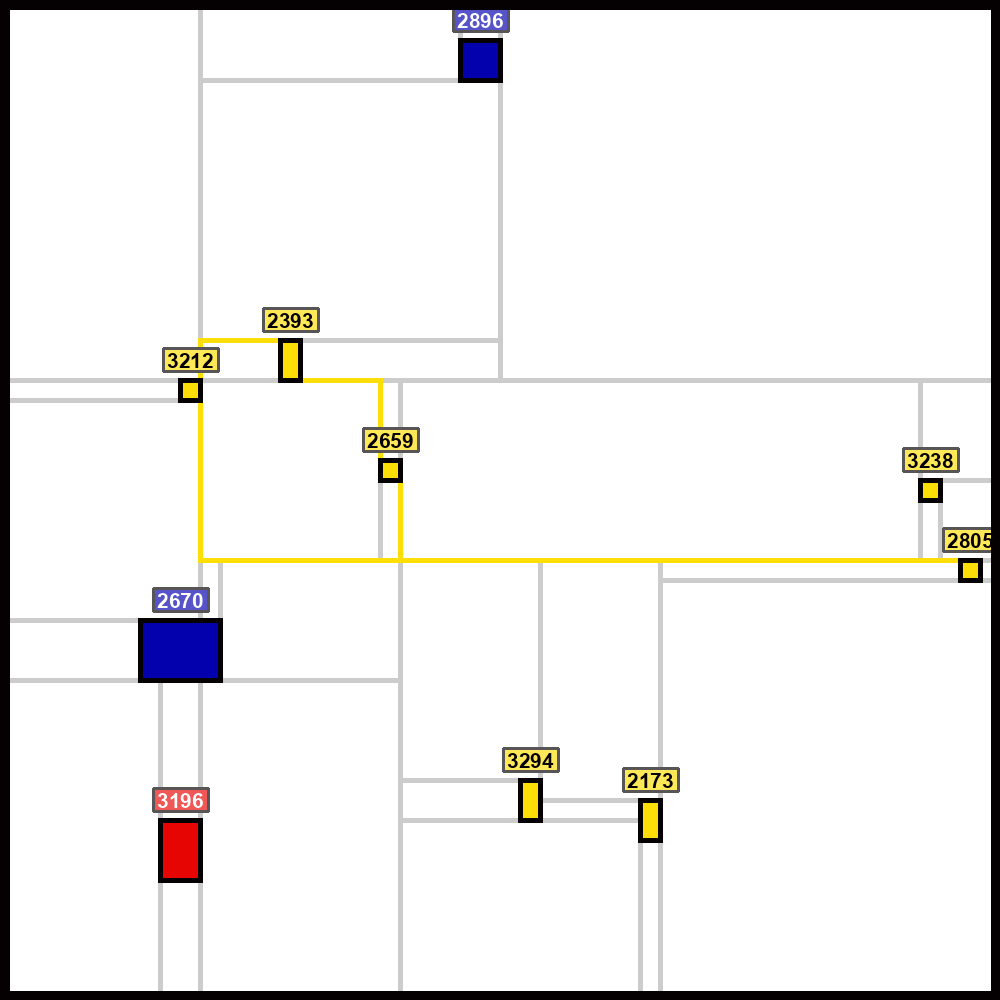

('3212', '2805') False False False
('2659', '2805') False False True
('2393', '2659') False False False
('3212', '2393') False False False


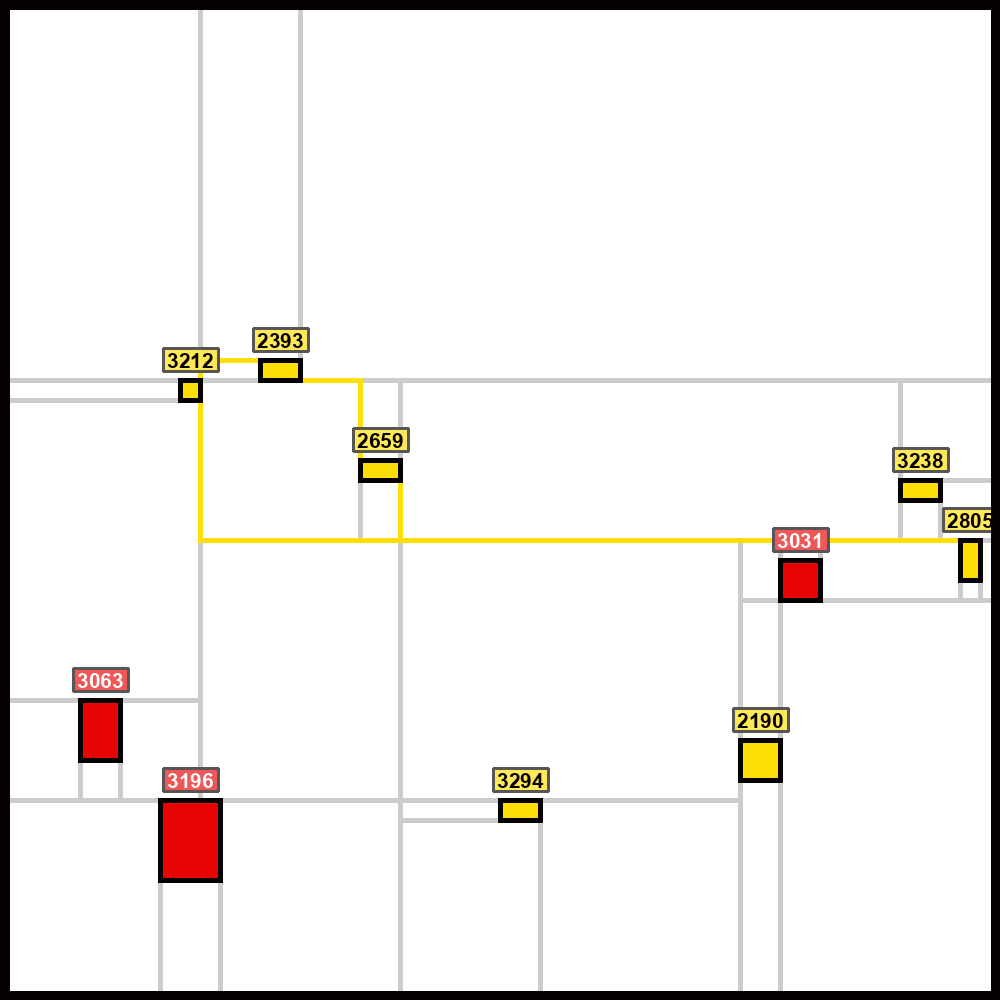

('2133', '2134') False False False
('3212', '2393') False False False


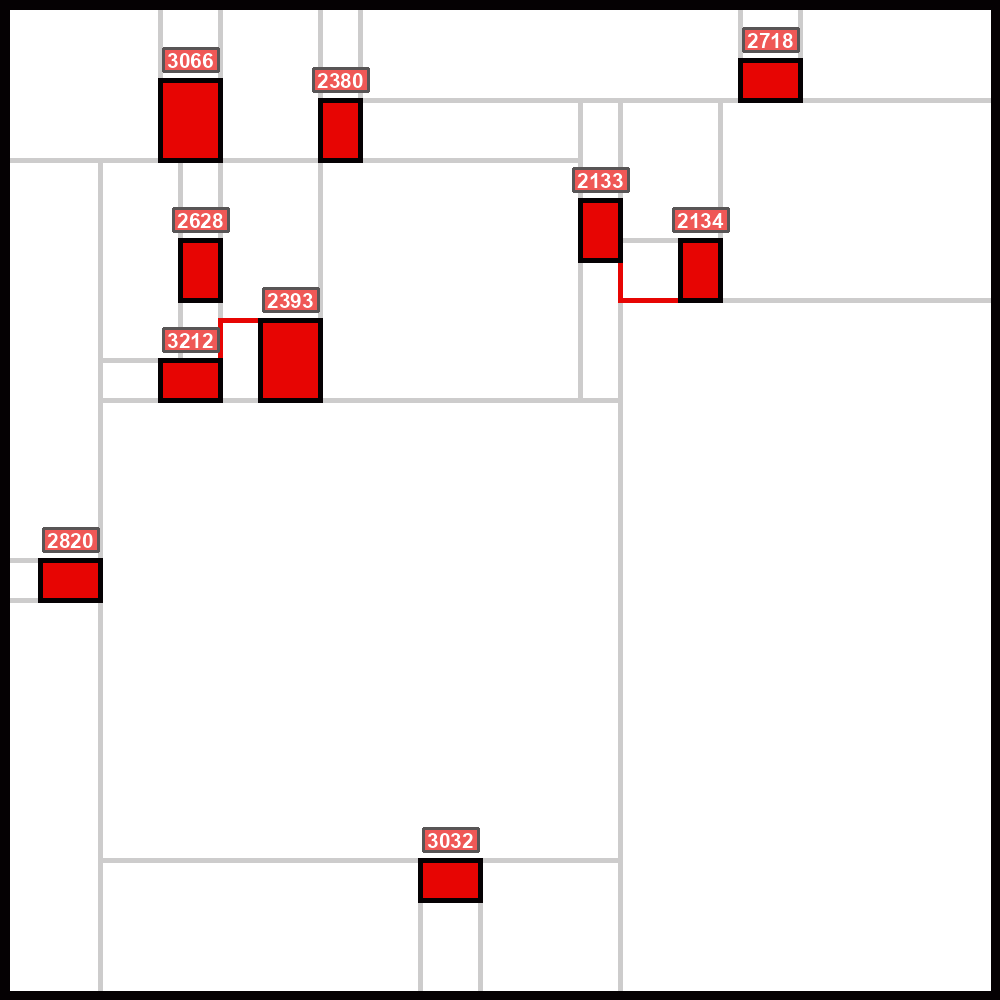

('2596', '3212') False False False
('2186', '2628') False False False
('2186', '2879') False False False
('2628', '2879') False False False
('2133', '2134') False False False


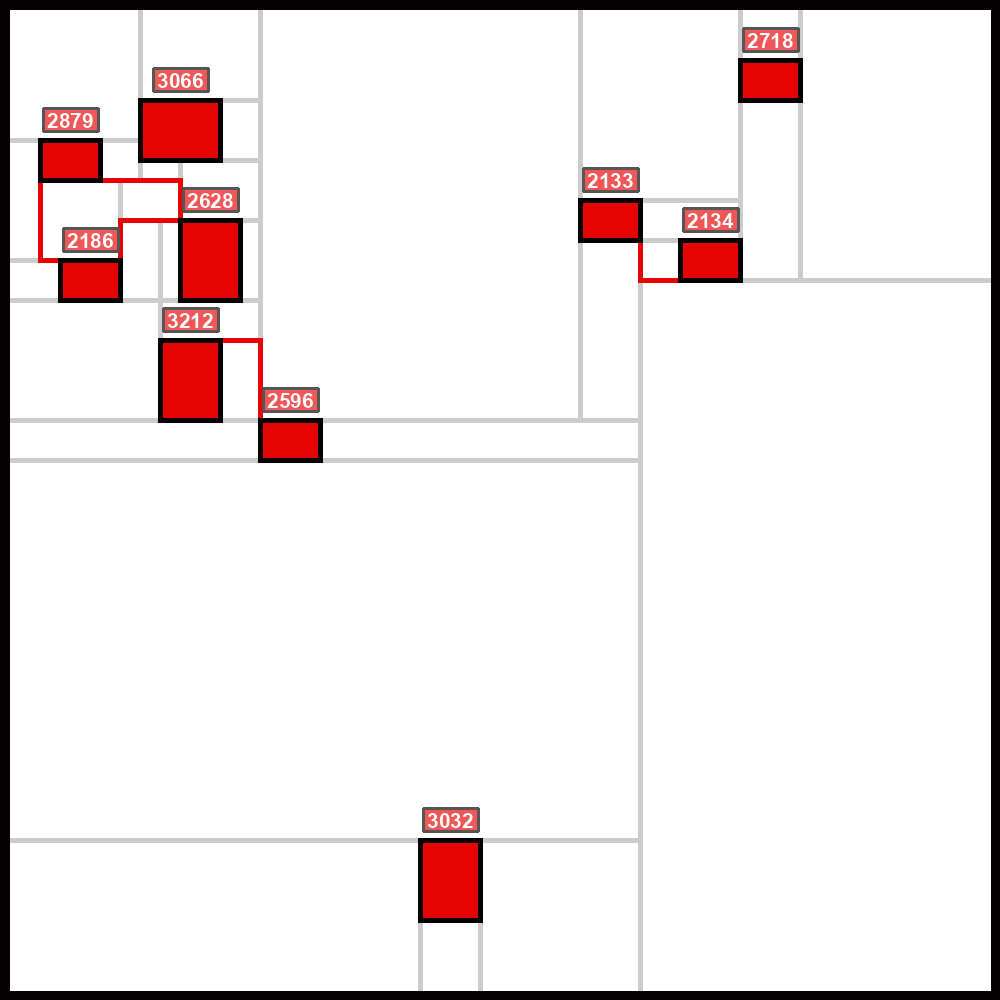

('2133', '2134') False False False
('2483', '2783') False False False
('2876', '2483') False False False
('2876', '2783') False False True


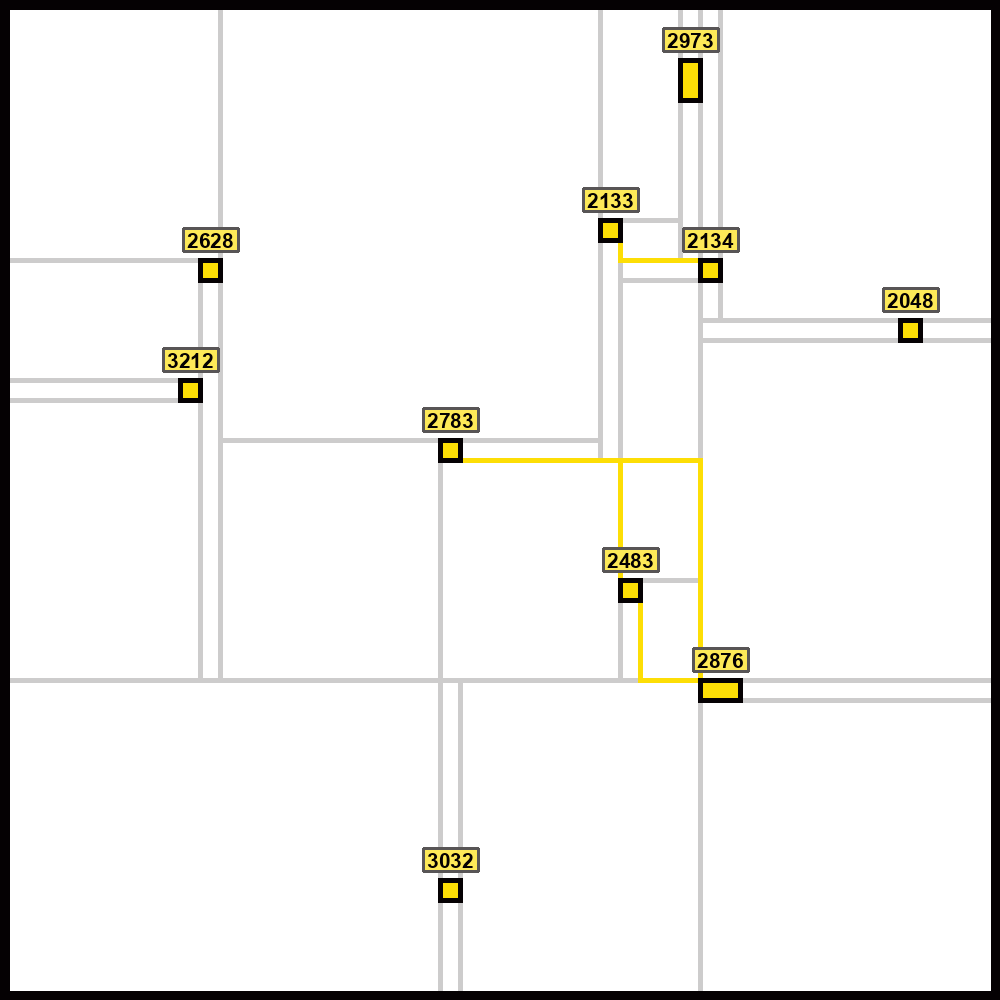

('2783', '2068') False False False
('2483', '2876') False False False
('2068', '2483') False False False
('3212', '3247') False False False
('2876', '2783') False False False
('2133', '2134') False False False


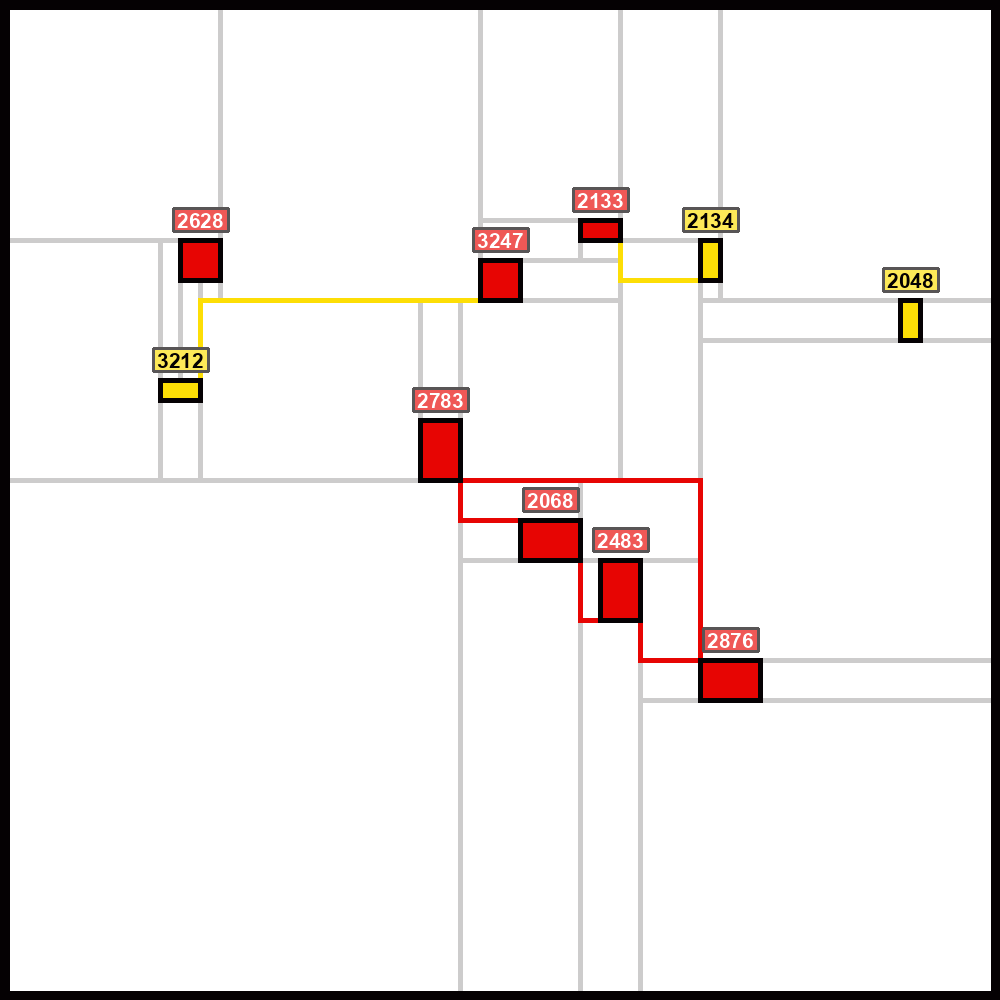

In [5]:
for profile in ["wikipathway_aggressive_R1_TP", "wikipathway_aggressive_R2_TP",
               "wikipathway_baseline_R1_TP", "wikipathway_baseline_R2_TP",
               "wikipathway_nonaggressive_R1_TP", "wikipathway_nonaggressive_R2_TP"]:
    
    df = pd.read_csv(f"../data/case_study/pathways_prepared_for_visualization/{profile}.csv")
    center_points = get_points(df, 1)
    areas = get_areas(df, AREA_SCALAR)                   # HYPERPARAMETER
    colors = get_colors(df, up_th, dn_th)
    pathway_ids = get_IDs(df)

    mem_df = pd.read_csv(f"../data/case_study/pathway_networks/{profile}.csv")
    mem_df = mem_df[mem_df["GS_A_ID"].isin(df["GS_ID"].unique()) & mem_df["GS_B_ID"].isin(df["GS_ID"].unique())].reset_index(drop=True)
    relations = get_relations(mem_df)

    blank_canvas()
    grid_system = GridSystem(1001, 1001, 20, 20)            # HYPERPARAMETER
    sorted_data = sorted(zip(areas, center_points, colors, pathway_ids), reverse=True)
    areas_sorted, center_points_sorted, colors, pathway_ids = zip(*sorted_data)

    rectangles, grid_with_filled_blocks_image, score = grid_system.plot_points_fill_blocks(center_points_sorted, areas_sorted, visualize=True)

    # STAGE 1
    img = Image.new('RGBA', (1000, 1000), color = 'white')
    draw = ImageDraw.Draw(img)

    Line(Point(0, 0), Point(1000, 0), LineDir.RIGHT)
    Line(Point(1000, 0), Point(1000, 1000), LineDir.DOWN)
    Line(Point(1000, 1000), Point(0, 1000), LineDir.LEFT)
    Line(Point(0, 1000), Point(0, 0), LineDir.UP)

    all_blocks = []
    for idx, rect in enumerate(rectangles):
        b = Block(rect[0], rect[1], areas_sorted[idx], colors[idx], pathway_ids[idx])
        # b.draw(img)
        all_blocks.append(b)


    all_manhattan_lines = []
    lines_to_extend = []
    for rel in relations:
        if rel[0] in Block.instances.keys() and rel[1] in Block.instances.keys():
            s = Block.instances[rel[0]]
            b = Block.instances[rel[1]]
        else:
            continue
        manhattan_line_color = get_manhattan_line_color(s, b)

        cp1 = get_closest_corner(s, b)
        cp2 = None
        dist = float('inf')

        for corner in [b.top_left, b.top_right, b.bottom_left, b.bottom_right]:
            if (s.top_left.point.x > corner.point.x or s.top_right.point.x < corner.point.x) and (s.top_left.point.y > corner.point.y or s.bottom_left.point.y < corner.point.y):
                d = euclidean_distance_point((s.center.x, s.center.y), (corner.point.x, corner.point.y))
                if d < dist:
                    cp2 = corner
                    dist = d
        if cp2 == None:
            cp2 = get_closest_corner(b, s)
            con = get_furthest_connector(cp1, cp2, s.center)
        else:
            con = get_furthest_connector(cp1, cp2, b.center)

        lines = get_manhattan_lines_2(cp1, cp2, con, manhattan_line_color)


        line_intersect = check_manhattan_line_intersection_other_lines(lines, all_manhattan_lines)

        if len(lines) == 1:
            all_manhattan_lines.append(lines[0])

        if len(lines) == 2:
            if get_line_lengths([lines[0]])[0] > LINE_WIDTH:
                all_manhattan_lines.append(lines[0])
                lines_to_extend.append(lines[0])
            if get_line_lengths([lines[1]])[0] > LINE_WIDTH:
                all_manhattan_lines.append(lines[1])

        atomic_line = is_atomic_line(lines, grid_system)
        block_intersect = check_manhattan_line_intersection(lines, rel)
        print(rel, atomic_line, block_intersect, line_intersect)

    # STAGE 2
    extended_lines = []
    for extend_line in lines_to_extend:
        vertical_lines = [line for line in Line.instances if line.direction in [LineDir.UP, LineDir.DOWN] and extend_line != line]
        horizontal_lines = [line for line in Line.instances if line.direction in [LineDir.LEFT, LineDir.RIGHT] and extend_line != line]
        l = None
        if extend_line.direction == LineDir.DOWN:
            h = get_nearest_horizontal_line_below(extend_line.point_b, horizontal_lines)
            start_point = Point(extend_line.point_b.x, extend_line.point_b.y)
            end_point = Point(extend_line.point_b.x, h.point_b.y - adjust_e)
            l = Line(start_point, end_point, get_line_direction(start_point, end_point), color=Colors.BLACK_A, strength=LINE_WIDTH)

        elif extend_line.direction == LineDir.UP:
            h = get_nearest_horizontal_line_above(extend_line.point_b, horizontal_lines)
            start_point = Point(extend_line.point_b.x, extend_line.point_b.y)
            end_point = Point(extend_line.point_b.x, h.point_b.y + adjust_e)
            l = Line(start_point, end_point, get_line_direction(start_point, end_point), color=Colors.BLACK_A, strength=LINE_WIDTH)

        elif extend_line.direction == LineDir.LEFT:
            h = get_nearest_vertical_line_left(extend_line.point_b, vertical_lines)
            start_point = Point(extend_line.point_b.x, extend_line.point_b.y)
            end_point = Point(h.point_b.x + adjust_e, extend_line.point_b.y)
            l = Line(start_point, end_point, get_line_direction(start_point, end_point), color=Colors.BLACK_A, strength=LINE_WIDTH)

        elif extend_line.direction == LineDir.RIGHT:
            h = get_nearest_vertical_line_right(extend_line.point_b, vertical_lines)
            start_point = Point(extend_line.point_b.x, extend_line.point_b.y)
            end_point = Point(h.point_b.x - adjust_e, extend_line.point_b.y)
            l = Line(start_point, end_point, get_line_direction(start_point, end_point), color=Colors.BLACK_A, strength=LINE_WIDTH)

        if l:
            extended_lines.append(l)

    # STAGE 3
    corner_lines = []
    for corner in Corner.instances:
        if corner.line == None:
            vertical_lines = [line for line in Line.instances if line.direction in [LineDir.UP, LineDir.DOWN]]
            horizontal_lines = [line for line in Line.instances if line.direction in [LineDir.LEFT, LineDir.RIGHT]]

            if corner.position == CornerPos.TOP_LEFT:
                v_line = get_nearest_vertical_line_left(corner.point, vertical_lines)
                h_line = get_nearest_horizontal_line_above(corner.point, horizontal_lines)
                v_dist = corner.point.x - v_line.point_a.x
                h_dist = corner.point.y - h_line.point_a.y
                # DECISION POINT
                if v_dist < h_dist:
                    corner_point = Point(corner.point.x, corner.point.y + adjust)
                    point_on_line = Point(v_line.point_a.x, corner.point.y + adjust)
                else:
                    corner_point = Point(corner.point.x + adjust, corner.point.y)
                    point_on_line = Point(corner.point.x + adjust, h_line.point_a.y)

            elif corner.position == CornerPos.TOP_RIGHT:
                v_line = get_nearest_vertical_line_right(corner.point, vertical_lines)
                h_line = get_nearest_horizontal_line_above(corner.point, horizontal_lines)
                v_dist = v_line.point_a.x - corner.point.x
                h_dist = corner.point.y - h_line.point_a.y
                if v_dist < h_dist:
                    corner_point = Point(corner.point.x, corner.point.y + adjust)
                    point_on_line = Point(v_line.point_a.x, corner.point.y + adjust)
                else:
                    corner_point = Point(corner.point.x - adjust, corner.point.y)
                    point_on_line = Point(corner.point.x - adjust, h_line.point_a.y)

            elif corner.position == CornerPos.BOTTOM_RIGHT:
                v_line = get_nearest_vertical_line_right(corner.point, vertical_lines)
                h_line = get_nearest_horizontal_line_below(corner.point, horizontal_lines)
                v_dist = v_line.point_a.x - corner.point.x
                h_dist = h_line.point_a.y - corner.point.y
                if v_dist < h_dist:
                    corner_point = Point(corner.point.x, corner.point.y - adjust)
                    point_on_line = Point(v_line.point_a.x, corner.point.y - adjust)
                else:
                    corner_point = Point(corner.point.x - adjust, corner.point.y)
                    point_on_line = Point(corner.point.x - adjust, h_line.point_a.y)

            elif corner.position == CornerPos.BOTTOM_LEFT:
                v_line = get_nearest_vertical_line_left(corner.point, vertical_lines)
                h_line = get_nearest_horizontal_line_below(corner.point, horizontal_lines)
                v_dist = corner.point.x - v_line.point_a.x
                h_dist = h_line.point_a.y - corner.point.y
                if v_dist < h_dist:
                    corner_point = Point(corner.point.x, corner.point.y - adjust)
                    point_on_line = Point(v_line.point_a.x, corner.point.y - adjust)
                else:
                    corner_point = Point(corner.point.x + adjust, corner.point.y)
                    point_on_line = Point(corner.point.x + adjust, h_line.point_a.y)

            l = Line(corner_point, point_on_line, get_line_direction(corner_point, point_on_line), color=Colors.BLACK_A, strength=LINE_WIDTH)
            corner_lines.append(l)

    for line in corner_lines:
        line.draw(img)

    for line in extended_lines:
        line.draw(img)

    for line in all_manhattan_lines:
        line.draw(img)

    for b in all_blocks:
        b.draw(img)

    draw.rectangle((0, 0, 1000, 1000), outline=Colors.BLACK, width=10)
    display(img)